In [ ]:
import os
import re

import numpy as np
import pandas as pd
import tables

import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score, r2_score, mean_absolute_error, mean_squared_error

In [ ]:
from gensim.models import FastText

from tensorflow.keras import backend as K
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Input, Embedding, Concatenate, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Add, Activation, Lambda, BatchNormalization, Concatenate, Dropout, Input, Embedding, Dot, Reshape, Dense, Flatten
from tensorflow.keras import regularizers

from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.utils import plot_model

2023-10-29 22:48:46.903201: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
taste_profile_df = pd.read_csv('/home/016709732/dataset/train_triplets.txt', sep='\t', header=None, names = ['user_id','song_id','play_count'], nrows = 2000000)
taste_profile_df.shape

(2000000, 3)

In [ ]:
taste_profile_df.head(8)

,user_id,song_id,play_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1
5,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBNZDC12A6D4FC103,1
6,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBSUJE12A6D4F8CF5,2
7,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBVFZR12A6D4F8AE3,1


In [ ]:
taste_profile_df.isnull().sum()

user_id       0
song_id       0
play_count    0
dtype: int64

In [ ]:
taste_profile_df.duplicated().sum()

0

In [ ]:
song_data_df = tables.open_file("/home/016709732/dataset/msd_summary_file.h5", mode="r")
song_data_table = song_data_df.root.metadata.songs
metadata_table_df = pd.DataFrame.from_records(song_data_table[:])
metadata_table_df.shape

(1000000, 20)

In [ ]:
metadata_table_df.drop(columns =['analyzer_version', 'artist_7digitalid','artist_id', 'idx_artist_terms','idx_similar_artists','release_7digitalid','artist_location','artist_longitude','artist_latitude','artist_playmeid','track_7digitalid','artist_mbid'],inplace=True)
metadata_table_df.replace({b'': np.nan}, inplace=True)
print(metadata_table_df.isna().sum())
metadata_table_df.drop(columns =['genre'],inplace=True)

artist_familiarity        185
artist_hotttnesss          12
artist_name                 0
genre                 1000000
release                     0
song_hotttnesss        418035
song_id                     0
title                      15
dtype: int64


In [ ]:
metadata_table_df = metadata_table_df.applymap(lambda x: x.decode('utf-8').strip('\'"') if isinstance(x, bytes) else x)
metadata_table_df.head(8)

/tmp/ipykernel_104076/1083272444.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  metadata_table_df = metadata_table_df.applymap(lambda x: x.decode('utf-8').strip('\'"') if isinstance(x, bytes) else x)


,artist_familiarity,artist_hotttnesss,artist_name,release,song_hotttnesss,song_id,title
0,0.649822,0.394032,Faster Pussy cat,Monster Ballads X-Mas,0.542899,SOQMMHC12AB0180CB8,Silent Night
1,0.439604,0.356992,Karkkiautomaatti,Karkuteillä,0.299877,SOVFVAK12A8C1350D9,Tanssi vaan
2,0.643681,0.437504,Hudson Mohawke,Butter,0.617871,SOGTUKN12AB017F4F1,No One Could Ever
3,0.448501,0.372349,Yerba Brava,De Culo,NaN,SOBNYVR12A8C13558C,Si Vos Querés
4,0.000000,0.000000,Der Mystic,Rene Ablaze Presents Winter Sessions,NaN,SOHSBXH12A8C13B0DF,Tangle Of Aspens
5,0.361287,0.109626,David Montgomery,Berwald: Symphonies Nos. 1/2/3/4,NaN,SOZVAPQ12A8C13B63C,"Symphony No. 1 G minor ""Sinfonie Serieuse""/All..."
6,0.692923,0.453732,Sasha / Turbulence,Strictly The Best Vol. 34,NaN,SOQVRHI12A6D4FB2D7,We Have Got Love
7,0.588156,0.401092,Kris Kross,Da Bomb,NaN,SOEYRFT12AB018936C,2 Da Beat Ch'yall


In [ ]:
track_metadata = pd.read_csv('/home/016709732/dataset/track_metadata.csv')
track_metadata.shape

(1000000, 14)

In [ ]:
track_metadata.drop(columns =['track_id', 'title','release', 'artist_id','artist_mbid','artist_name','artist_familiarity','artist_hotttnesss','year', 'track_7digitalid','shs_perf','shs_work'], inplace=True)

In [ ]:
track_metadata = track_metadata.drop(track_metadata[track_metadata.duration > 480].index)
track_metadata = track_metadata.drop(track_metadata[track_metadata.duration < 60].index)

In [ ]:
track_metadata.drop_duplicates(inplace=True)
track_metadata.shape

(942370, 2)

In [ ]:
track_merge = pd.merge(track_metadata, taste_profile_df, on='song_id', how="right")
song_data = pd.merge(metadata_table_df, track_merge, on='song_id', how="right")
song_data.shape

(2128559, 10)

In [ ]:
song_data = song_data.dropna()
song_data.drop_duplicates(inplace=True)
song_data.shape

(1776948, 10)

In [ ]:
def remove_outliers(df, column_name):
    q1 = df[column_name].quantile(0.25)
    q3 = df[column_name].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    df = df[(df[column_name] >= lower) & (df[column_name] <= upper)]
    return df

song_data = remove_outliers(song_data, 'play_count')
song_data = remove_outliers(song_data, 'artist_familiarity')
song_data = remove_outliers(song_data, 'artist_hotttnesss')
song_data = remove_outliers(song_data, 'song_hotttnesss')
song_data = remove_outliers(song_data, 'duration')
song_data.shape

(1428056, 10)

In [ ]:
song_data = song_data.reset_index(drop=True)
song_data.head(5)

,artist_familiarity,artist_hotttnesss,artist_name,release,song_hotttnesss,song_id,title,duration,user_id,play_count
0,0.832012,0.677482,Jack Johnson,Thicker Than Water,0.649006,SOAKIMP12A8C130995,The Cove,112.63955,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1
1,0.580555,0.482492,Billy Preston,To Die For,0.826375,SOAPDEY12A81C210A9,Nothing from Nothing,153.59955,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1
2,0.633119,0.417718,Paco De Lucia,Flamenco Para Niños,0.735295,SOBBMDR12A8C13253B,Entre Dos Aguas,358.24281,b80344d063b5ccb3212f76538f3d9e43d87dca9e,2
3,0.650281,0.451749,The Dead 60s,Nick & Norah's Infinite Playlist - Original Mo...,0.754628,SOBFOVM12A58A7D494,Riot Radio (Soundtrack Version),141.42649,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1
4,0.576127,0.436974,Amset,Amset,0.454193,SOBNZDC12A6D4FC103,Sin límites (I),190.53669,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1


In [ ]:
song_data['unencoded_sid'] = song_data['song_id']
song_data['unencoded_uid'] = song_data['user_id']

In [ ]:
data_encoder = LabelEncoder()
song_data['song_id'] = data_encoder.fit_transform(song_data['song_id'])
song_data['user_id'] = data_encoder.fit_transform(song_data['user_id'])

In [ ]:
song_dict = dict(zip(song_data['unencoded_sid'], song_data['song_id']))
user_dict = dict(zip(song_data['unencoded_uid'], song_data['user_id']))
song_data.drop(columns =['unencoded_sid'], inplace=True)
song_data.drop(columns =['unencoded_uid'], inplace=True)
song_data.head(8)

,artist_familiarity,artist_hotttnesss,artist_name,release,song_hotttnesss,song_id,title,duration,user_id,play_count
0,0.832012,0.677482,Jack Johnson,Thicker Than Water,0.649006,2078,The Cove,112.63955,29941,1
1,0.580555,0.482492,Billy Preston,To Die For,0.826375,3051,Nothing from Nothing,153.59955,29941,1
2,0.633119,0.417718,Paco De Lucia,Flamenco Para Niños,0.735295,5461,Entre Dos Aguas,358.24281,29941,2
3,0.650281,0.451749,The Dead 60s,Nick & Norah's Infinite Playlist - Original Mo...,0.754628,6263,Riot Radio (Soundtrack Version),141.42649,29941,1
4,0.576127,0.436974,Amset,Amset,0.454193,7956,Sin límites (I),190.53669,29941,1
5,0.641037,0.412069,Jorge Drexler,10 + Downloaded,0.265861,8982,12 segundos de oscuridad,246.83057,29941,2
6,0.675339,0.499641,Josh Rouse,Under Cold Blue Stars,0.645846,9466,Ears To The Ground (Album Version),171.17995,29941,1
7,0.806208,0.498077,Eric Hutchinson,Sounds Like This,0.345802,9823,Food Chain (Album Version),221.20444,29941,1


In [ ]:
scaler = MinMaxScaler()
track_metadata['duration'] = scaler.fit_transform(track_metadata[['duration']])

In [ ]:
song_data['title'] = song_data['title'].apply(lambda x: re.sub(r'[^\w\s]', '', str(x)))
song_data['title'] = song_data['title'].apply(lambda x: x.lower())

song_data['artist_name'] = song_data['artist_name'].apply(lambda x: str(x).lower())
song_data['artist_name'] = song_data['artist_name'].apply(lambda x: re.sub(r'[^\w\s]', '', str(x)))

song_data['release'] = song_data['release'].apply(lambda x: str(x).lower())
song_data['release'] = song_data['release'].apply(lambda x: re.sub(r'[^\w\s]', '', str(x)))

In [ ]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(song_data, test_size=0.1, random_state=42)

In [ ]:
inputs = ['user_id', 'song_id', 'artist_name', 'title', 'release', 'duration', 'artist_familiarity', 'artist_hotttnesss', 'song_hotttnesss']
target = ['play_count']

train_input = train_data[inputs].copy()
train_target = train_data[target]

inputs = ['user_id', 'song_id', 'artist_name', 'title', 'release', 'duration', 'artist_familiarity', 'artist_hotttnesss', 'song_hotttnesss']
target = ['play_count']

test_input = test_data[inputs].copy()
test_target = test_data[target]

text_data = ['artist_name', 'title', 'release']
meta_text = train_data[text_data].copy()

test_text_data = ['artist_name', 'title', 'release']
test_meta_text = test_data[test_text_data].copy()

train_input.shape, meta_text.shape, test_input.shape, test_meta_text.shape

((1285250, 9), (1285250, 3), (142806, 9), (142806, 3))

In [ ]:
meta_text['text'] = meta_text.apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
corpus = [text.split() for text in meta_text['text']]
emb_size = 30
model_ft = FastText(sentences=corpus, vector_size=emb_size, window=5, min_count=1, workers=4, sg=0)

test_meta_text['text'] = test_meta_text.apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
corpus = [text.split() for text in test_meta_text['text']]
emb_size = 30
test_model_ft = FastText(sentences=corpus, vector_size=emb_size, window=5, min_count=1, workers=4, sg=0)

text_vector = []
for text in meta_text['text']:
    vec = np.zeros(emb_size)
    tokens = text.split()
    for token in tokens:
        if token in model_ft.wv:
            vec += model_ft.wv[token]
    text_vector.append(vec)

text_vector = np.array(text_vector)

test_text_vector = []
for text in test_meta_text['text']:
    vec = np.zeros(emb_size)
    tokens = text.split()
    for token in tokens:
        if token in test_model_ft.wv:
            vec += test_model_ft.wv[token]
    test_text_vector.append(vec)

test_text_vector = np.array(test_text_vector)
text_vector.shape, test_text_vector.shape

((1285250, 30), (142806, 30))

In [ ]:
train_cols = train_input[['duration', 'artist_familiarity', 'artist_hotttnesss', 'song_hotttnesss']].values
train_with_meta = np.concatenate((text_vector, train_cols), axis=1)
train_with_meta.shape

test_cols = test_input[['duration', 'artist_familiarity', 'artist_hotttnesss', 'song_hotttnesss']].values
test_with_meta = np.concatenate((test_text_vector, test_cols), axis=1)
test_with_meta.shape

song_col = ['song_id']
user_col = ['user_id']

song_input = train_input[song_col].copy()
user_input = train_input[user_col].copy()
song_input.shape, user_input.shape

test_song_input = test_input[song_col].copy()
test_user_input = test_input[user_col].copy()
test_song_input.shape,test_user_input.shape

max_song_id = max(train_input.song_id)
max_user_id = max(train_input.user_id)
song_input_dim = 1
user_input_dim = 1

meta_text_dim = train_with_meta.shape[1]

max_song_id, max_user_id, song_input_dim, user_input_dim, meta_text_dim

(127853, 41690, 1, 1, 34)

In [ ]:
input_song = Input(shape=(song_input_dim,), name='song_input')
input_user = Input(shape=(user_input_dim,), name='user_input')
input_meta = Input(shape=(meta_text_dim,), name='metadata_input')

song_encoding = Embedding(max_song_id+1 ,10, embeddings_regularizer=regularizers.L2(0.001))(input_song)
song_embeddings = Flatten()(song_encoding)

user_encoding = Embedding(max_user_id+1 ,10, embeddings_regularizer=regularizers.L2(0.001))(input_user)
user_embeddings = Flatten()(user_encoding)

dense_layer = Dense(64, activation='relu')(input_meta)
metadata_embeddings = Dense(10, activation='relu', name='metadata_embeddings')(dense_layer)

concat = Concatenate()([song_embeddings, user_embeddings, metadata_embeddings])
hidden_layer = Dense(16, activation='relu', kernel_regularizer=regularizers.L2(0.001))(concat)
hidden_layer = Dense(8, activation='relu', kernel_regularizer=regularizers.L2(0))(hidden_layer)

lambda_layer = Lambda(lambda x: K.clip(x, 0.0, 7.0))
output_layer = Dense(1,activation=lambda_layer, kernel_initializer='lecun_uniform', name='output')(hidden_layer)

model = tf.keras.Model([input_song, input_user, input_meta], output_layer)

2023-10-29 23:02:35.652490: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-29 23:02:35.664854: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [ ]:
optimizer = Adam(lr=0.001, epsilon = 1e-6, amsgrad=True)
model.compile(optimizer='adam', loss='mse', metrics=['accuracy', tf.keras.metrics.RootMeanSquaredError()])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 song_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 user_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 metadata_input (InputLayer)    [(None, 34)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 10)        1278540     ['song_input[0][0]']             
                                                                                              

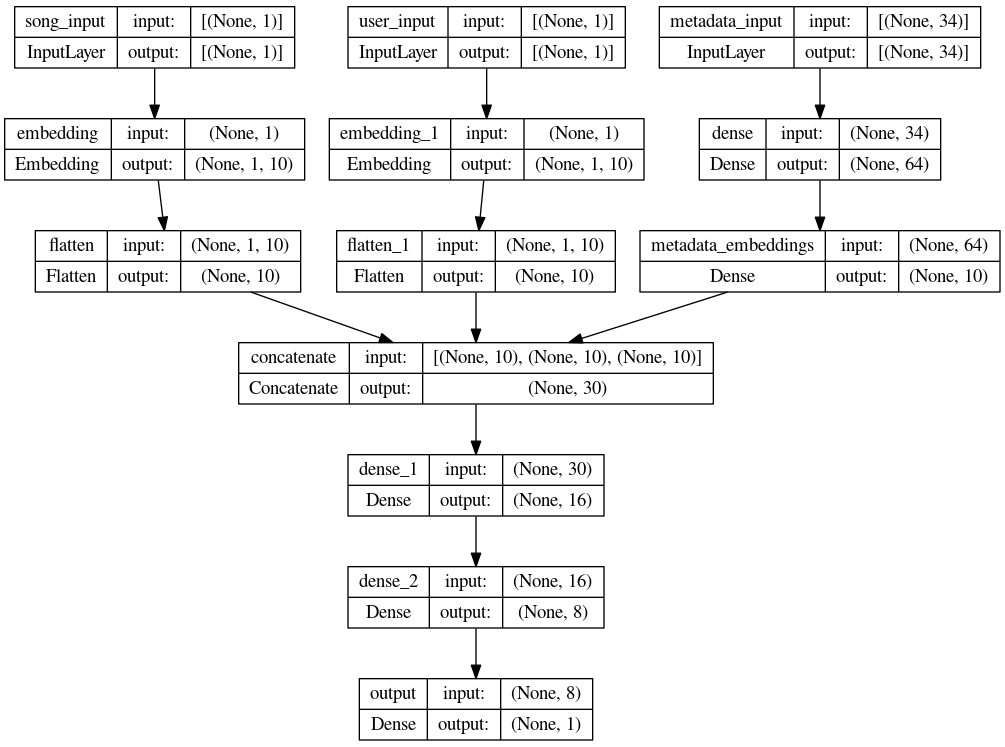

In [ ]:
plot_model(model, to_file='model.png', show_shapes = True, show_layer_names = True)

In [ ]:
record_model_callback = LambdaCallback(
    on_batch_end=lambda batch, logs: (
        loss_values.append(logs['loss']),
        acc_values.append(logs['accuracy']),
        rmse_values.append(np.sqrt(logs['root_mean_squared_error']))))

loss_values = []
rmse_values = []
acc_values = []

In [ ]:
history = model.fit(
  [song_input, user_input, train_with_meta], train_target,
  batch_size = 512,
  epochs = 5,
  verbose = 1,
  callbacks = [record_model_callback],
  validation_split=0.1
)

Epoch 1/5
2260/2260 [==============================] - 36s 15ms/step - loss: 1.7970 - accuracy: 0.6356 - root_mean_squared_error: 1.3124 - val_loss: 1.6441 - val_accuracy: 0.6456 - val_root_mean_squared_error: 1.2310
Epoch 2/5
2260/2260 [==============================] - 36s 16ms/step - loss: 1.6305 - accuracy: 0.6446 - root_mean_squared_error: 1.2231 - val_loss: 1.5994 - val_accuracy: 0.6456 - val_root_mean_squared_error: 1.2136
Epoch 3/5
2260/2260 [==============================] - 36s 16ms/step - loss: 1.5785 - accuracy: 0.6446 - root_mean_squared_error: 1.2080 - val_loss: 1.5611 - val_accuracy: 0.6456 - val_root_mean_squared_error: 1.2045
Epoch 4/5
2260/2260 [==============================] - 38s 17ms/step - loss: 1.5389 - accuracy: 0.6446 - root_mean_squared_error: 1.1976 - val_loss: 1.5342 - val_accuracy: 0.6456 - val_root_mean_squared_error: 1.1993
Epoch 5/5
2260/2260 [==============================] - 36s 16ms/step - loss: 1.5187 - accuracy: 0.6446 - root_mean_squared_error: 1.

In [ ]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
print("Training accuracy: ", train_acc)
print("Validation accuracy: ", train_acc)

Training accuracy:  [0.6356229782104492, 0.6446242332458496, 0.6446259617805481, 0.6446259617805481, 0.6446259617805481]
Validation accuracy:  [0.6356229782104492, 0.6446242332458496, 0.6446259617805481, 0.6446259617805481, 0.6446259617805481]


In [ ]:
train_pred = model.predict([song_input, user_input, train_with_meta])
train_gt = train_target.values
train_rmse = np.sqrt(np.mean((train_pred - train_gt)**2))
print("Train RMSE: ", train_rmse)

40165/40165 [==============================] - 134s 3ms/step
Train RMSE:  1.1646467692059175


In [ ]:
test_pred = model.predict([test_song_input, test_user_input, test_with_meta])
test_gt = test_target.values
test_rmse = np.sqrt(np.mean((test_pred - test_gt)**2))
test_rmse
print("Test RMSE: ", test_rmse)

4463/4463 [==============================] - 14s 3ms/step
Test RMSE:  1.2697808877155499


In [ ]:
train_mae = mean_absolute_error(train_pred, train_gt)
test_mae = mean_absolute_error(test_pred, test_gt)
print("Train MAE: ", train_mae)
print("Test MAE: ", test_mae)

Train MAE:  0.8507981726075629
Test MAE:  0.9347381223557488


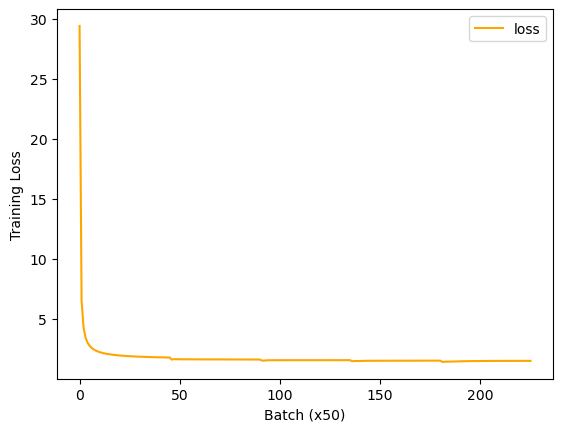

In [ ]:
plt_loss_values = loss_values[::50]
plt.plot(np.arange(len(plt_loss_values)), plt_loss_values, label='loss', color = 'orange')
plt.xlabel('Batch (x50)')
plt.ylabel('Training Loss')
plt.legend()
plt.show()

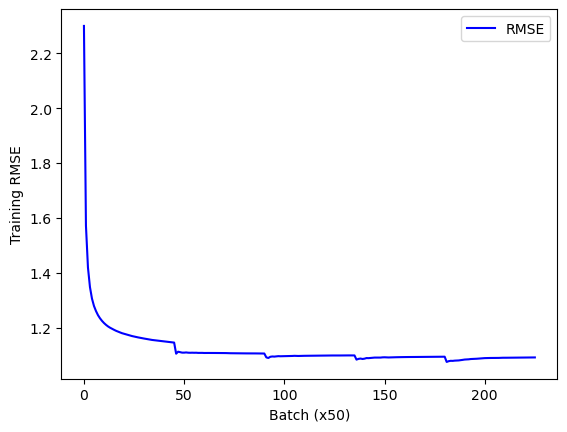

In [ ]:
plt_rmse_values = rmse_values[::50]
plt.plot(np.arange(len(plt_rmse_values)), plt_rmse_values, label='RMSE', color='blue')
plt.xlabel('Batch (x50)')
plt.ylabel('Training RMSE')
plt.legend()
plt.show()

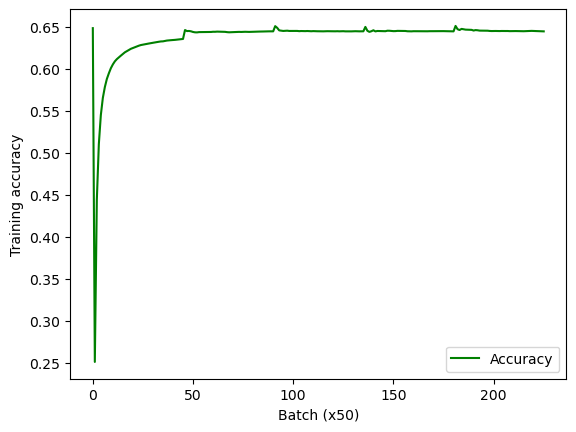

In [ ]:
plt_acc_values = acc_values[::50]
plt.plot(np.arange(len(plt_acc_values)), plt_acc_values, label='Accuracy', color='green')
plt.xlabel('Batch (x50)')
plt.ylabel('Training accuracy')
plt.legend()
plt.show()